### Notebook for annotating the 6mpi MoMacs (goal: preserve UMAP)

#### Environment: Scanpy

- **Developed by**: Alexandra Cirnu
- **Modified by**: Alexandra Cirnu
- **Talavera-López Lab - Würzburg Institute for Systems Immunology - Faculty of Medicine - Julius Maximilian Universität Würzburg**
- **Created on**: 240324
- **Last modified**: 240324

##### Load required modules

In [6]:
import anndata
import logging
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams
from scipy.sparse import csr_matrix

In [7]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

sc.settings.set_figure_params(dpi=100)
%matplotlib inline

-----
anndata     0.10.5.post1
scanpy      1.9.8
-----
PIL                 10.2.0
asttokens           NA
colorama            0.4.6
comm                0.2.1
cycler              0.12.1
cython_runtime      NA
dateutil            2.8.2
debugpy             1.8.1
decorator           5.1.1
exceptiongroup      1.2.0
executing           2.0.1
h5py                3.10.0
igraph              0.11.4
ipykernel           6.29.2
ipywidgets          8.1.2
jedi                0.19.1
joblib              1.3.2
kiwisolver          1.4.5
leidenalg           0.10.2
llvmlite            0.42.0
matplotlib          3.8.3
matplotlib_inline   0.1.6
mpl_toolkits        NA
natsort             8.4.0
numba               0.59.0
numpy               1.26.4
packaging           23.2
pandas              2.2.1
parso               0.8.3
patsy               0.5.6
pickleshare         0.7.5
platformdirs        4.2.0
prompt_toolkit      3.0.42
psutil              5.9.8
pure_eval           0.2.2
pydev_ipython       NA
pydevconsol

In [8]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

##### Load in dataset that was clustered with `leiden`

In [9]:
adata = sc.read_h5ad('/home/acirnu/data/ACM_cardiac_leuco/Test_scVI_MoMac_sameUMAP_leiden_ac240322.raw.h5ad')

### Clustering the neighborhood graph

/home/acirnu/miniforge3/envs/Scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/acirnu/miniforge3/envs/Scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


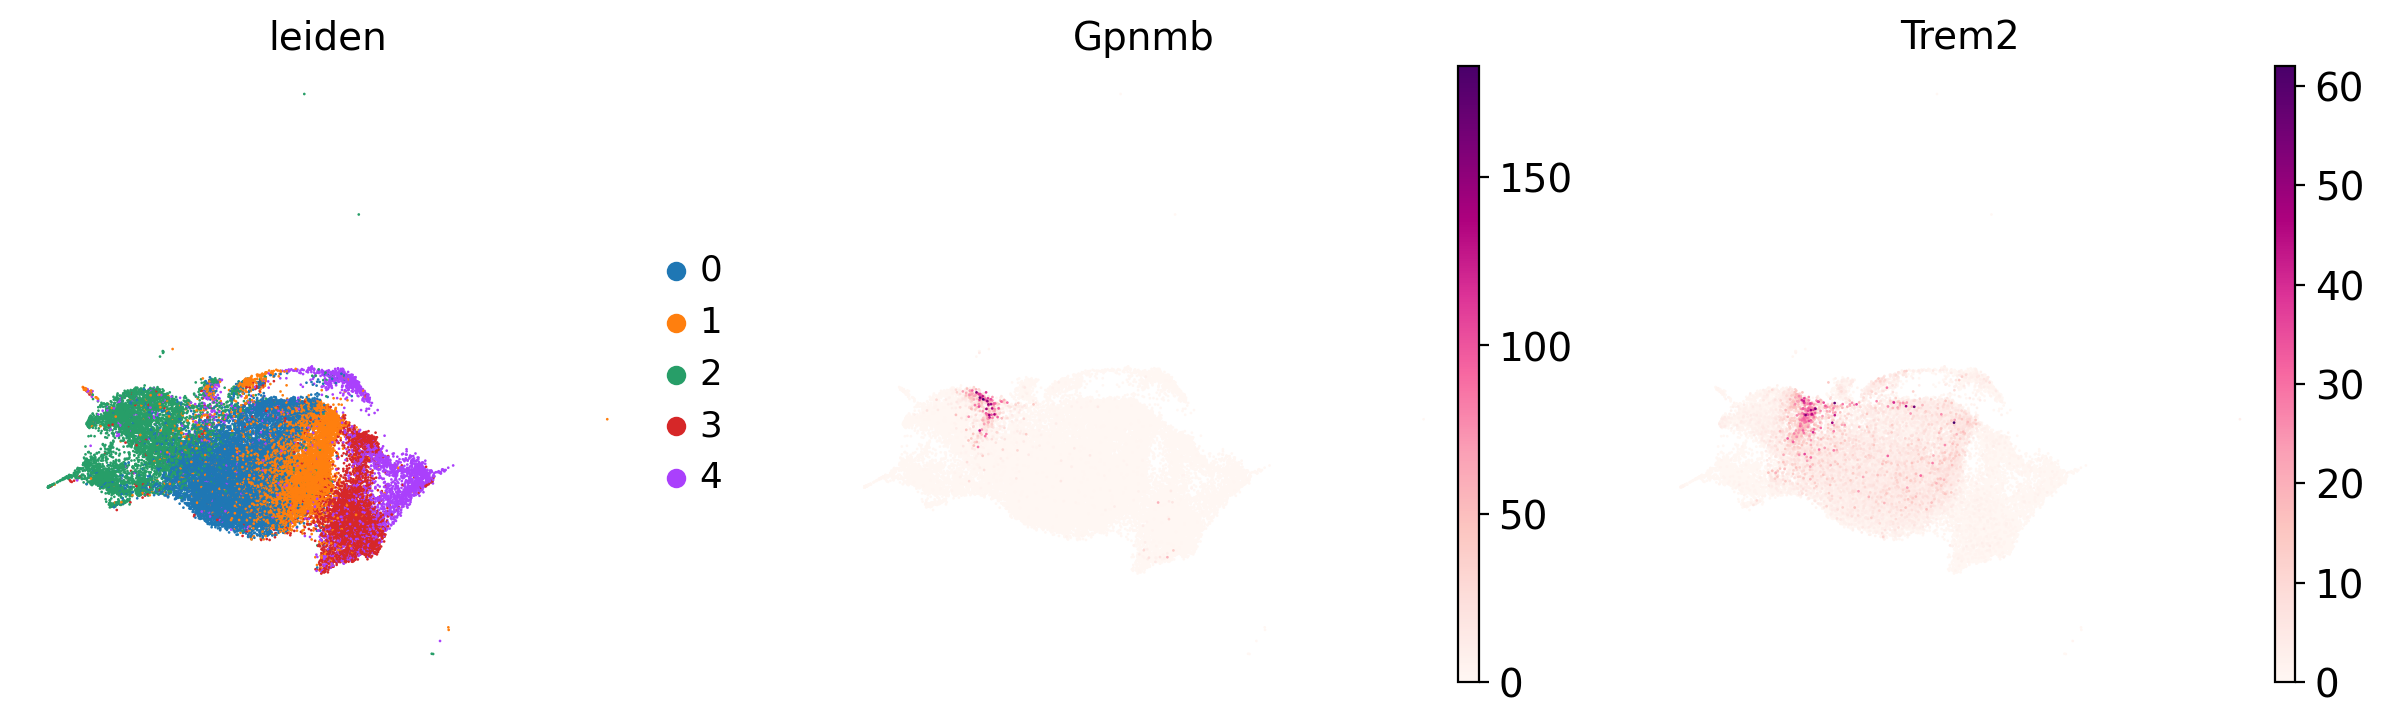

In [10]:
sc.pl.umap(adata, color=["leiden", "Gpnmb", "Trem2"], color_map='RdPu', frameon=False)

### Finding marker genes

In [11]:
sc.settings.verbosity = 2

ranking genes


/home/acirnu/miniforge3/envs/Scanpy/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


    finished (0:00:42)


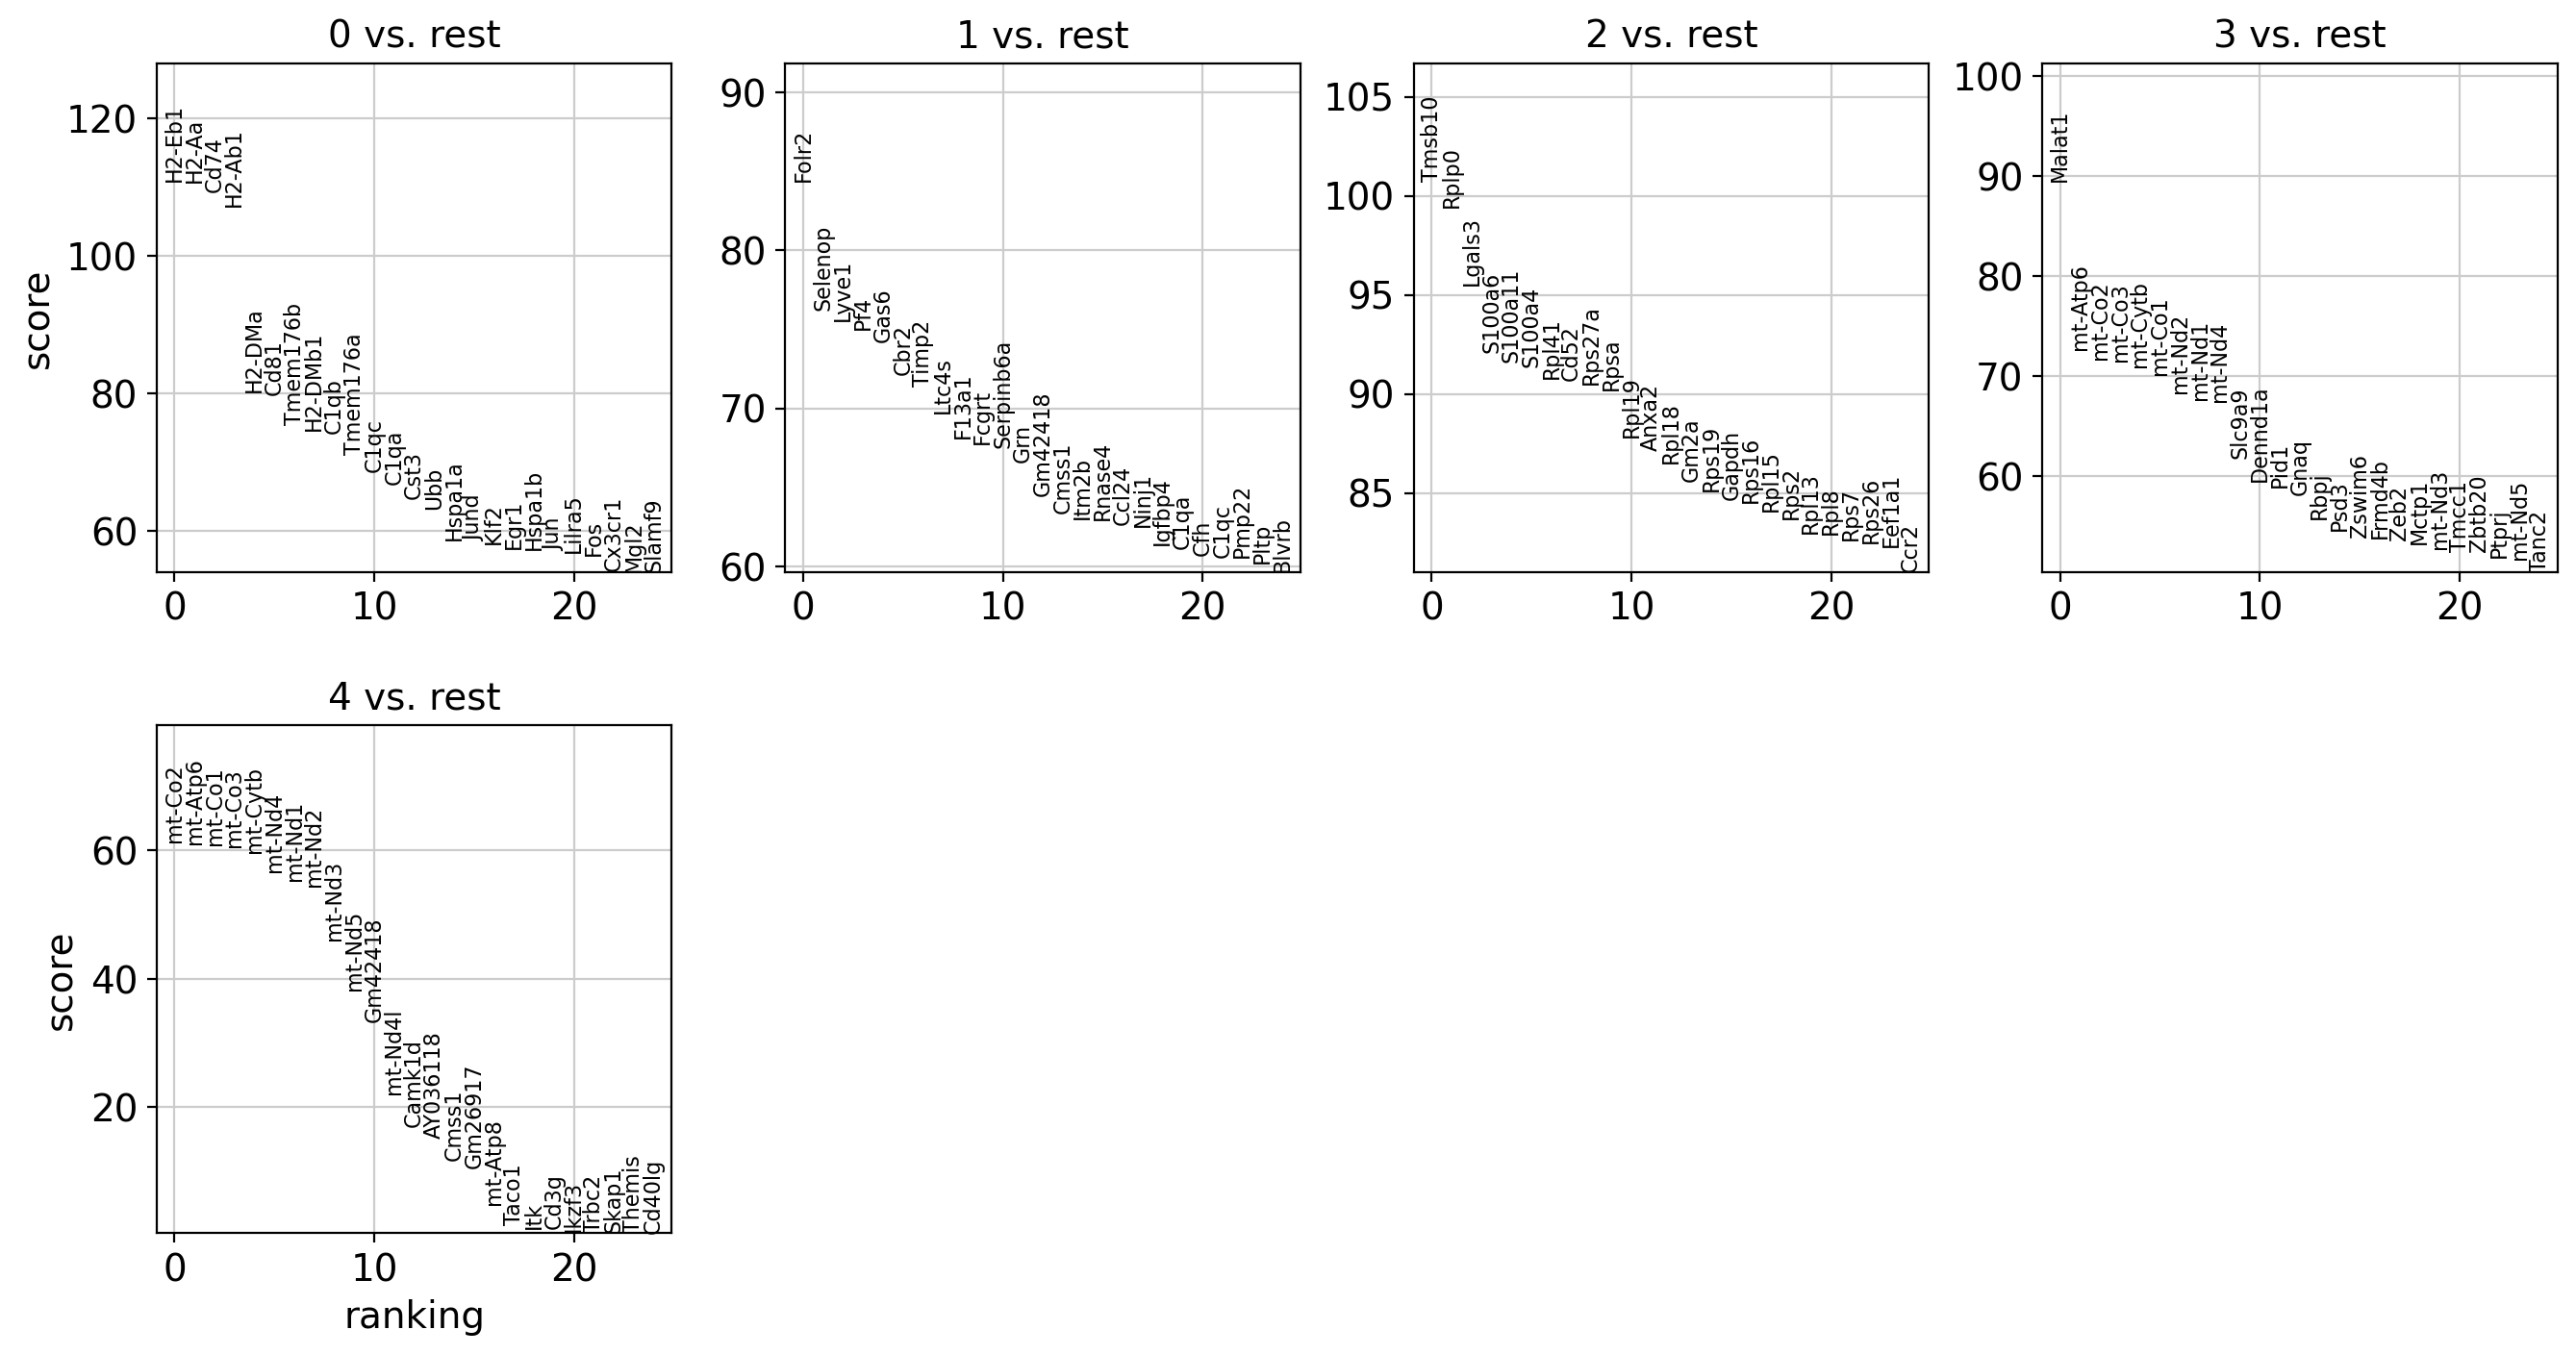

In [12]:
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon", use_raw=False, layer='log_norm')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Save the results

In [13]:
adata.write_h5ad('/home/acirnu/data/ACM_cardiac_leuco/Test_scVI_MoMac_sameUMAP_find_markers_ac240324.raw.h5ad')

#### Show the top10 ranked genes per cluster

In [14]:
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(10)

,0,1,2,3,4
0,H2-Eb1,Folr2,Tmsb10,Malat1,mt-Co2
1,H2-Aa,Selenop,Rplp0,mt-Atp6,mt-Atp6
2,Cd74,Lyve1,Lgals3,mt-Co2,mt-Co1
3,H2-Ab1,Pf4,S100a6,mt-Co3,mt-Co3
4,H2-DMa,Gas6,S100a11,mt-Cytb,mt-Cytb
5,Cd81,Cbr2,S100a4,mt-Co1,mt-Nd4
6,Tmem176b,Timp2,Rpl41,mt-Nd2,mt-Nd1
7,H2-DMb1,Ltc4s,Cd52,mt-Nd1,mt-Nd2
8,C1qb,F13a1,Rps27a,mt-Nd4,mt-Nd3
9,Tmem176a,Fcgrt,Rpsa,Slc9a9,mt-Nd5


In [15]:
# Initialize an empty list to store arrays for vertical stacking
out = []
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names

# Iterate over each group
for group in groups:
    # Stack arrays vertically and append to the 'out' list
    out.append(np.vstack((
        result['names'][group],
        result['scores'][group],
        result['pvals_adj'][group],
        result['logfoldchanges'][group],
        np.array([group] * len(result['names'][group])).astype('object')
    )).T)

# Vertically stack all arrays in the 'out' list
out = np.vstack(out)

#Create a data frame
markers = pd.DataFrame(out, columns= ['Gene', 'Score', 'Adj_pvalue', 'Logfoldchange', 'Cluster'])

In [16]:
markers_filtered = markers[(markers.Adj_pvalue < 0.05) & (abs(markers.Logfoldchange) > 1)]

In [17]:
#To see the marker genes for each cluster vary the number in markers_filtered.Cluster

markers_0 = markers_filtered[markers_filtered.Cluster == '0']
markers_0.head(10)

,Gene,Score,Adj_pvalue,Logfoldchange,Cluster
0,H2-Eb1,110.883614,0.0,3.460731,0
1,H2-Aa,110.641891,0.0,3.210506,0
2,Cd74,109.244255,0.0,2.614758,0
3,H2-Ab1,107.229568,0.0,3.423284,0
4,H2-DMa,80.26329,0.0,3.388976,0
5,Cd81,79.750275,0.0,3.778259,0
6,Tmem176b,75.482948,0.0,2.995111,0
7,H2-DMb1,74.586273,0.0,3.654897,0
8,C1qb,74.213142,0.0,2.377604,0
9,Tmem176a,71.143974,0.0,3.143052,0


### Create a HeatMap

/tmp/ipykernel_834684/3697217196.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sorted_markers = markers.groupby('Cluster', group_keys=False).apply(lambda x: x.nlargest(10, 'Logfoldchange'))


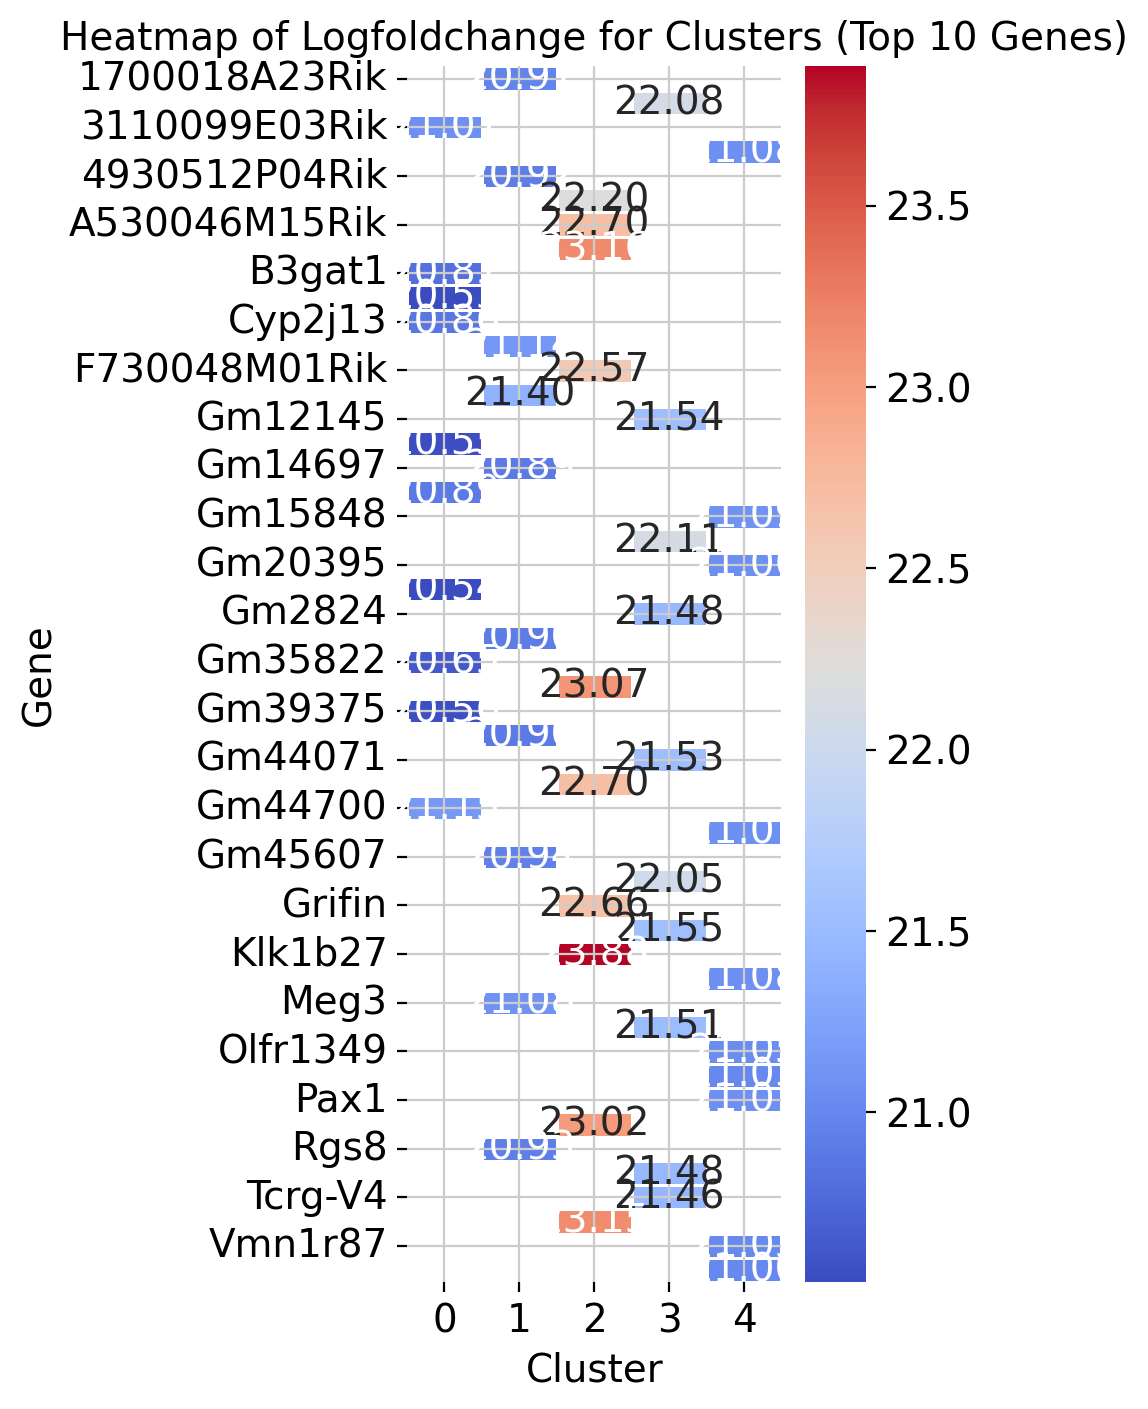

In [19]:

# Convert Logfoldchange column to numeric
markers['Logfoldchange'] = markers['Logfoldchange'].astype(float)

# Sort the dataframe by Logfoldchange within each cluster
sorted_markers = markers.groupby('Cluster', group_keys=False).apply(lambda x: x.nlargest(10, 'Logfoldchange'))

# Pivot the sorted data frame to have 'Genes' as rows, 'Cluster' as columns, and 'Logfoldchange' as values
heatmap_data = sorted_markers.pivot(index='Gene', columns='Cluster', values='Logfoldchange')

# Create heatmap
plt.figure(figsize=(3, 8))
sb.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title('Heatmap of Logfoldchange for Clusters (Top 10 Genes)')
plt.xlabel('Cluster')
plt.ylabel('Gene')
plt.show()

# Did not go further! Continue with annotating the clusters